# Setup

* Create virtualenv using python 3.6.8
* Install pytorch (via...)
* Install VizDoom binaries
* Install scikit-image
* Install scipy
* Install tqdm

Run program..

todo:
    run an initial test
    get cuda working (just for pytorch, see how much faster it is.
    

On CPU I get ~20 it/s, took 38.24 minutes, score is ~86

On GPU I still get ~20 it/s, but CPU usage is only 50%, presumably I'm limited by single core speed for vizdoom.        

In [143]:
# have a look at the results...
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math

In [144]:
db = pickle.load(open("results.dat","rb"))

param_names = ["score"]+list(db[0]["params"].keys())
print("Param names:",param_names)

scores = []

for result in db:
    final_score = result["test_scores_mean"][-1]
    params = list(result["params"].values())
    params[0] = math.log10(params[0])    # learning rate is exp
    params[1] = math.log10(1-params[1])  # gamma is exp
    params[2] = math.log10(params[2])    # replay buffer is exp
    params[3] = math.log10(params[3])    # explore rate is exp
    params[4] = math.log2(params[4])     # batch_size is exp
    scores.append([final_score]+params)
    

scores = np.asarray(scores)
print("Loaded {} samples.".format(len(scores)))
print("Top score was {}.".format(max(scores[:,0])))

Param names: ['score', 'learning_rate', 'discount_factor', 'replay_memory_size', 'end_epsilon', 'batch_size', 'frame_repeat']
Loaded 67 samples.
Top score was 86.69.


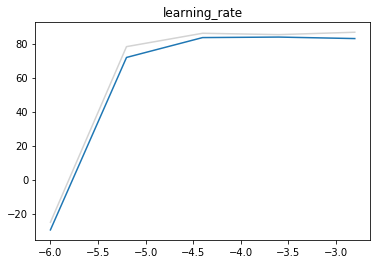

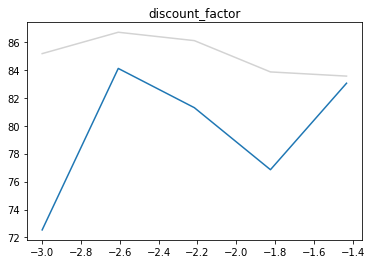

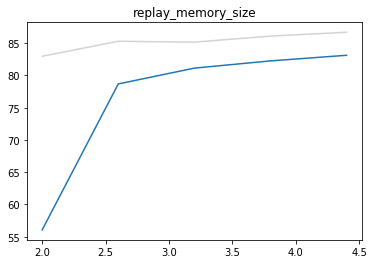

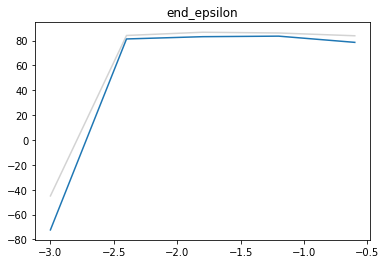

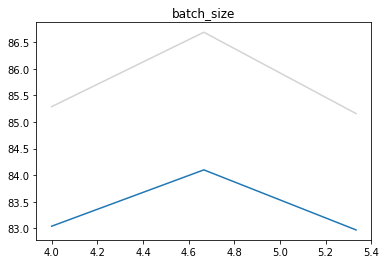

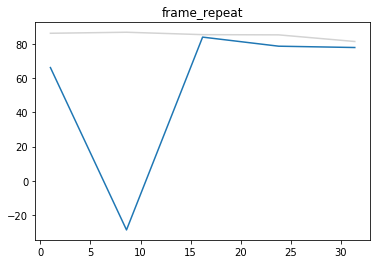

In [145]:
# bucket method

# last bucket may only every get 1 entry??

def bucket_plot(param_index, top_x=5, bin_count=5):
    
    bins = np.linspace(min(scores[:,param_index]), max(scores[:,param_index]), bin_count, endpoint=False)
    inds = np.digitize(scores[:,param_index], bins) -1 # 0 index the bins        
    
    x = bins
    y_avg = np.zeros(len(x))
    y_min = np.zeros(len(x))
    y_max = np.zeros(len(x))

    for bin_index in range(bin_count):
        # look for top 5 in this bin
        sample = scores[inds[:] == bin_index]        
        
        # will happen sometimes if count is very low, or bin_count is high
        if len(sample) == 0:
            print("Warning bin {} has no samples.".format(bin_index+1))
            continue

        top_scores = sorted(sample[:,0],reverse=True)[:top_x]        
        y_avg[bin_index] = np.median(top_scores)
        y_min[bin_index] = np.min(top_scores)
        y_max[bin_index] = np.max(top_scores)                        
        
        if len(top_scores) < top_x:
            print("Warning bin {} has too few samples ({}).".format(bin_index+1, len(top_scores)))
    
    plt.title(param_names[param_index])
    #plt.plot(x,y_min,c="lightgray")
    plt.plot(x,y_max,c="lightgray")
    plt.plot(x,y_avg)
    
    plt.show()

for i in range(1,7):
    bucket_plot(i, bin_count=3 if i == 5 else 5)

In [139]:
# ideas
# 1/ 5 bins, use average of top 5
# 2/ use sliding window again with average
# 3/ use convex hull, with bootstrapping
# 4/ create gif of graphs evolving over samples (10 through to 100? or 1000?)